<a href="https://colab.research.google.com/github/MarianoChic09/Agentes-Inteligentes/blob/main/TDL2023_Obligatorio_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 105038771.45it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27160469.47it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37119746.86it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4673829.43it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [5]:
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(input_dim=z_dim, output_dim=mnist_dim).cuda()
D = Discriminator(input_dim=mnist_dim).cuda()

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [10]:
num_epochs = 2000
losses_g = []
losses_d = []

for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).cuda()

        # Etiquetas
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()

        # ===== Entrenamiento del discriminador =====
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ===== Entrenamiento del generador =====
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        losses_g.append(g_loss.item())
        losses_d.append(d_loss.item())

    print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')



Epoch [0/2000], d_loss: 0.6078, g_loss: 1.8790, D(x): 0.77, D(G(z)): 0.20
Epoch [1/2000], d_loss: 0.9999, g_loss: 2.1988, D(x): 0.65, D(G(z)): 0.25
Epoch [2/2000], d_loss: 0.8157, g_loss: 1.8061, D(x): 0.73, D(G(z)): 0.27
Epoch [3/2000], d_loss: 0.7725, g_loss: 1.9381, D(x): 0.71, D(G(z)): 0.22
Epoch [4/2000], d_loss: 0.7260, g_loss: 1.5017, D(x): 0.84, D(G(z)): 0.34
Epoch [5/2000], d_loss: 0.8763, g_loss: 1.3499, D(x): 0.74, D(G(z)): 0.33
Epoch [6/2000], d_loss: 0.9383, g_loss: 1.6986, D(x): 0.75, D(G(z)): 0.34
Epoch [7/2000], d_loss: 0.8419, g_loss: 1.8623, D(x): 0.73, D(G(z)): 0.26
Epoch [8/2000], d_loss: 1.0521, g_loss: 1.7055, D(x): 0.63, D(G(z)): 0.26
Epoch [9/2000], d_loss: 0.8751, g_loss: 1.9987, D(x): 0.63, D(G(z)): 0.15
Epoch [10/2000], d_loss: 0.6479, g_loss: 2.1023, D(x): 0.73, D(G(z)): 0.16
Epoch [11/2000], d_loss: 0.9564, g_loss: 2.0202, D(x): 0.70, D(G(z)): 0.30
Epoch [12/2000], d_loss: 0.8859, g_loss: 1.9218, D(x): 0.70, D(G(z)): 0.26
Epoch [13/2000], d_loss: 0.8479, g_

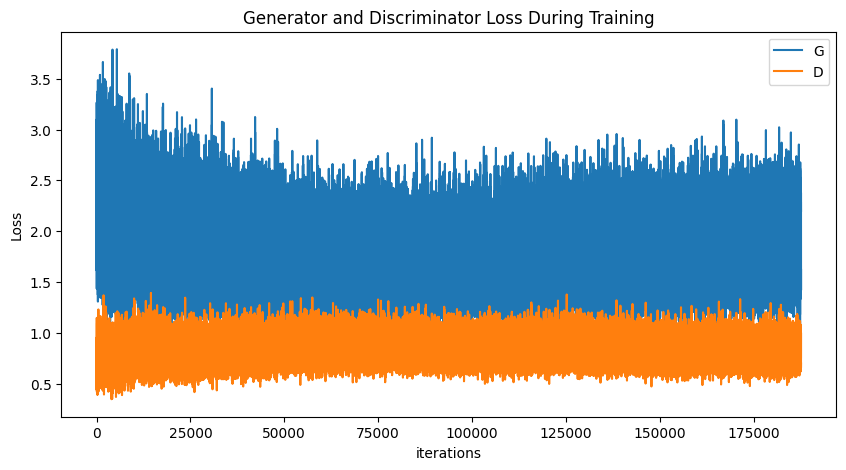

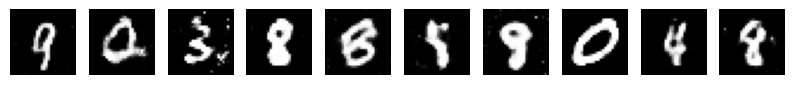

In [9]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g, label="G")
plt.plot(losses_d, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

def show_fake_images(generator, num_images=10):
    z = torch.randn(num_images, z_dim).cuda()
    fake_images = generator(z)
    fake_images = fake_images.view(fake_images.size(0), 28, 28).data.cpu().numpy()

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

show_fake_images(G)
